# 주가 예측 모델 구축

## 1. 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras import regularizers

In [2]:
esgu = pd.read_csv('../데이터셋/ESGU.csv', encoding='cp949')
erth = pd.read_csv('../데이터셋/^GSPC.csv', encoding='cp949')
vde = pd.read_csv('../데이터셋/VDE.csv', encoding='cp949')
nulg = pd.read_csv('../데이터셋/NULG.csv', encoding='cp949')
tan = pd.read_csv('../데이터셋/TAN.csv', encoding='cp949')
susa = pd.read_csv('../데이터셋/SUSA.csv', encoding='cp949')

# 전통 에너지 관련 주가 데이터
xom = pd.read_csv('../데이터셋/XOM.csv')
eog = pd.read_csv('../데이터셋/EOG.csv')
mpc = pd.read_csv('../데이터셋/MPC.csv')
kmi = pd.read_csv('../데이터셋/KMI.csv')
btu = pd.read_csv('../데이터셋/BTU.csv')

# 친환경 에너지 관련 주가 데이터
nee = pd.read_csv('../데이터셋/NEE.csv')
fslr = pd.read_csv('../데이터셋/FSLR.csv')
enph = pd.read_csv('../데이터셋/ENPH.csv')
run = pd.read_csv('../데이터셋/RUN.csv')

## 2. 뉴스 감성 점수 병합

In [3]:
# 뉴스 감성 점수 데이터 로드 (이전에 감성 분석한 결과)
news_df = pd.read_csv("../데이터셋/news_sentiment_analysis.csv")

# 날짜 정리
news_df['Date'] = pd.to_datetime(news_df['Date'])

# 날짜별 평균 감성 점수 계산
news_sentiment = news_df.groupby('Date')['Sentiment_Score'].mean().reset_index()


## 3. 전처리

In [4]:
def stock_pre(df):
    # 7번째 행 삭제
    df.drop(df.columns[6], axis=1, inplace=True)
    # 열 이름 통일
    new_columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume']
    df.columns = new_columns
    # 날짜로 정렬
    df.sort_values('Date',ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df['Date'] = pd.to_datetime(df['Date'])  # 날짜 형식 변환
    df = df.merge(news_sentiment, on='Date', how='left')  # 새로운 데이터프레임이 생성되지만, 원본은 변경되지 않음
    df['Sentiment_Score'].fillna(0, inplace=True)

    # 시작 날짜와 종료 날짜를 설정
    start = '2016-01-01'
    end = '2025-02-01'

    # 이 기간 동안의 데이터만 필터링
    df = df[(df['Date'] >= start) & (df['Date'] <= end)]
    
    df.index = df["Date"]
    df.drop("Date", axis = 1, inplace = True)
    df

    # bfill로 결측값 채우기
    df.bfill(axis=0, inplace=True)  # 행 방향으로 결측값 채우기
    # ffill로 결측값 채우기
    df.ffill(axis=0, inplace=True)  # 행 방향으로 결측값 채우기
    return df

In [5]:
tan = stock_pre(tan)

## 4. 모델

In [6]:
TARGET = "Close"
SEQ_SIZE = 50
PRED_SIZE = 1
EPOCH = 30
BATCH_SIZE = 32

def split_xy(dataset, time_steps, y_column):
    x, y = [], []
    for i in range(len(dataset) - time_steps - y_column):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column
        x.append(dataset.iloc[i:x_end_number, :].values)
        y.append(dataset.iloc[x_end_number:y_end_number, :][TARGET].values)
    return np.array(x), np.array(y)

X, y = split_xy(tan, SEQ_SIZE, PRED_SIZE)
print(X[0], "\n", y[0])
print("X size:", X.shape)
print("y size:", y.shape)


[[ 2.83203945e+01  2.83203945e+01  2.72619466e+01  2.76577127e+01
   2.22400000e+05  0.00000000e+00]
 [ 2.78878117e+01  2.88082015e+01  2.78141805e+01  2.85873082e+01
   2.18900000e+05  0.00000000e+00]
 [ 2.73447819e+01  2.77037351e+01  2.71146844e+01  2.73815983e+01
   4.02900000e+05  0.00000000e+00]
 [ 2.48413220e+01  2.64980247e+01  2.46940597e+01  2.64059854e+01
   4.48300000e+05  0.00000000e+00]
 [ 2.51266460e+01  2.58261427e+01  2.50346085e+01  2.57525115e+01
   2.19400000e+05  0.00000000e+00]
 [ 2.42246628e+01  2.53935584e+01  2.39761571e+01  2.52462962e+01
   2.25100000e+05  0.00000000e+00]
 [ 2.37000389e+01  2.50069926e+01  2.34331250e+01  2.48137098e+01
   3.50600000e+05  0.00000000e+00]
 [ 2.28716888e+01  2.44271482e+01  2.26876102e+01  2.40681950e+01
   2.23700000e+05  0.00000000e+00]
 [ 2.30189514e+01  2.31478054e+01  2.20985615e+01  2.28624851e+01
   2.22500000e+05  0.00000000e+00]
 [ 2.16475697e+01  2.20525399e+01  2.09664814e+01  2.17948319e+01
   2.48100000e+05  0.0000

In [7]:
# 시퀀스별로 Min-Max 정규화
scaler = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)
y_scaled = scaler.fit_transform(y)

# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)


### 4.1 GRU

In [8]:
# 초기화 함수 정의
initializer = GlorotNormal()

# 모델 구성
model = Sequential()
model.add(BatchNormalization())
model.add(GRU(128, input_shape=(SEQ_SIZE, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.002)))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCH, validation_split=0.2, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f'테스트 손실: {loss}')

# 예측
y_pred = model.predict(X_test)


Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.3555 - val_loss: 0.1607
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.1336 - val_loss: 0.1634
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.1047 - val_loss: 0.1516
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0935 - val_loss: 0.1275
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0840 - val_loss: 0.1158
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0780 - val_loss: 0.0984
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0727 - val_loss: 0.0889
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0711 - val_loss: 0.0691
Epoch 9/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0666 - val_loss: 0.0623
Epoch 10/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0628 - val_loss: 0.0557
Epoch 11/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0583 - val_loss: 0.0534
Epoch 12/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.

In [9]:
# 성능 평가 지표
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {round(mse, 4)}')
print(f'MAE: {round(mae, 4)}')


MSE: 0.0007
MAE: 0.0182


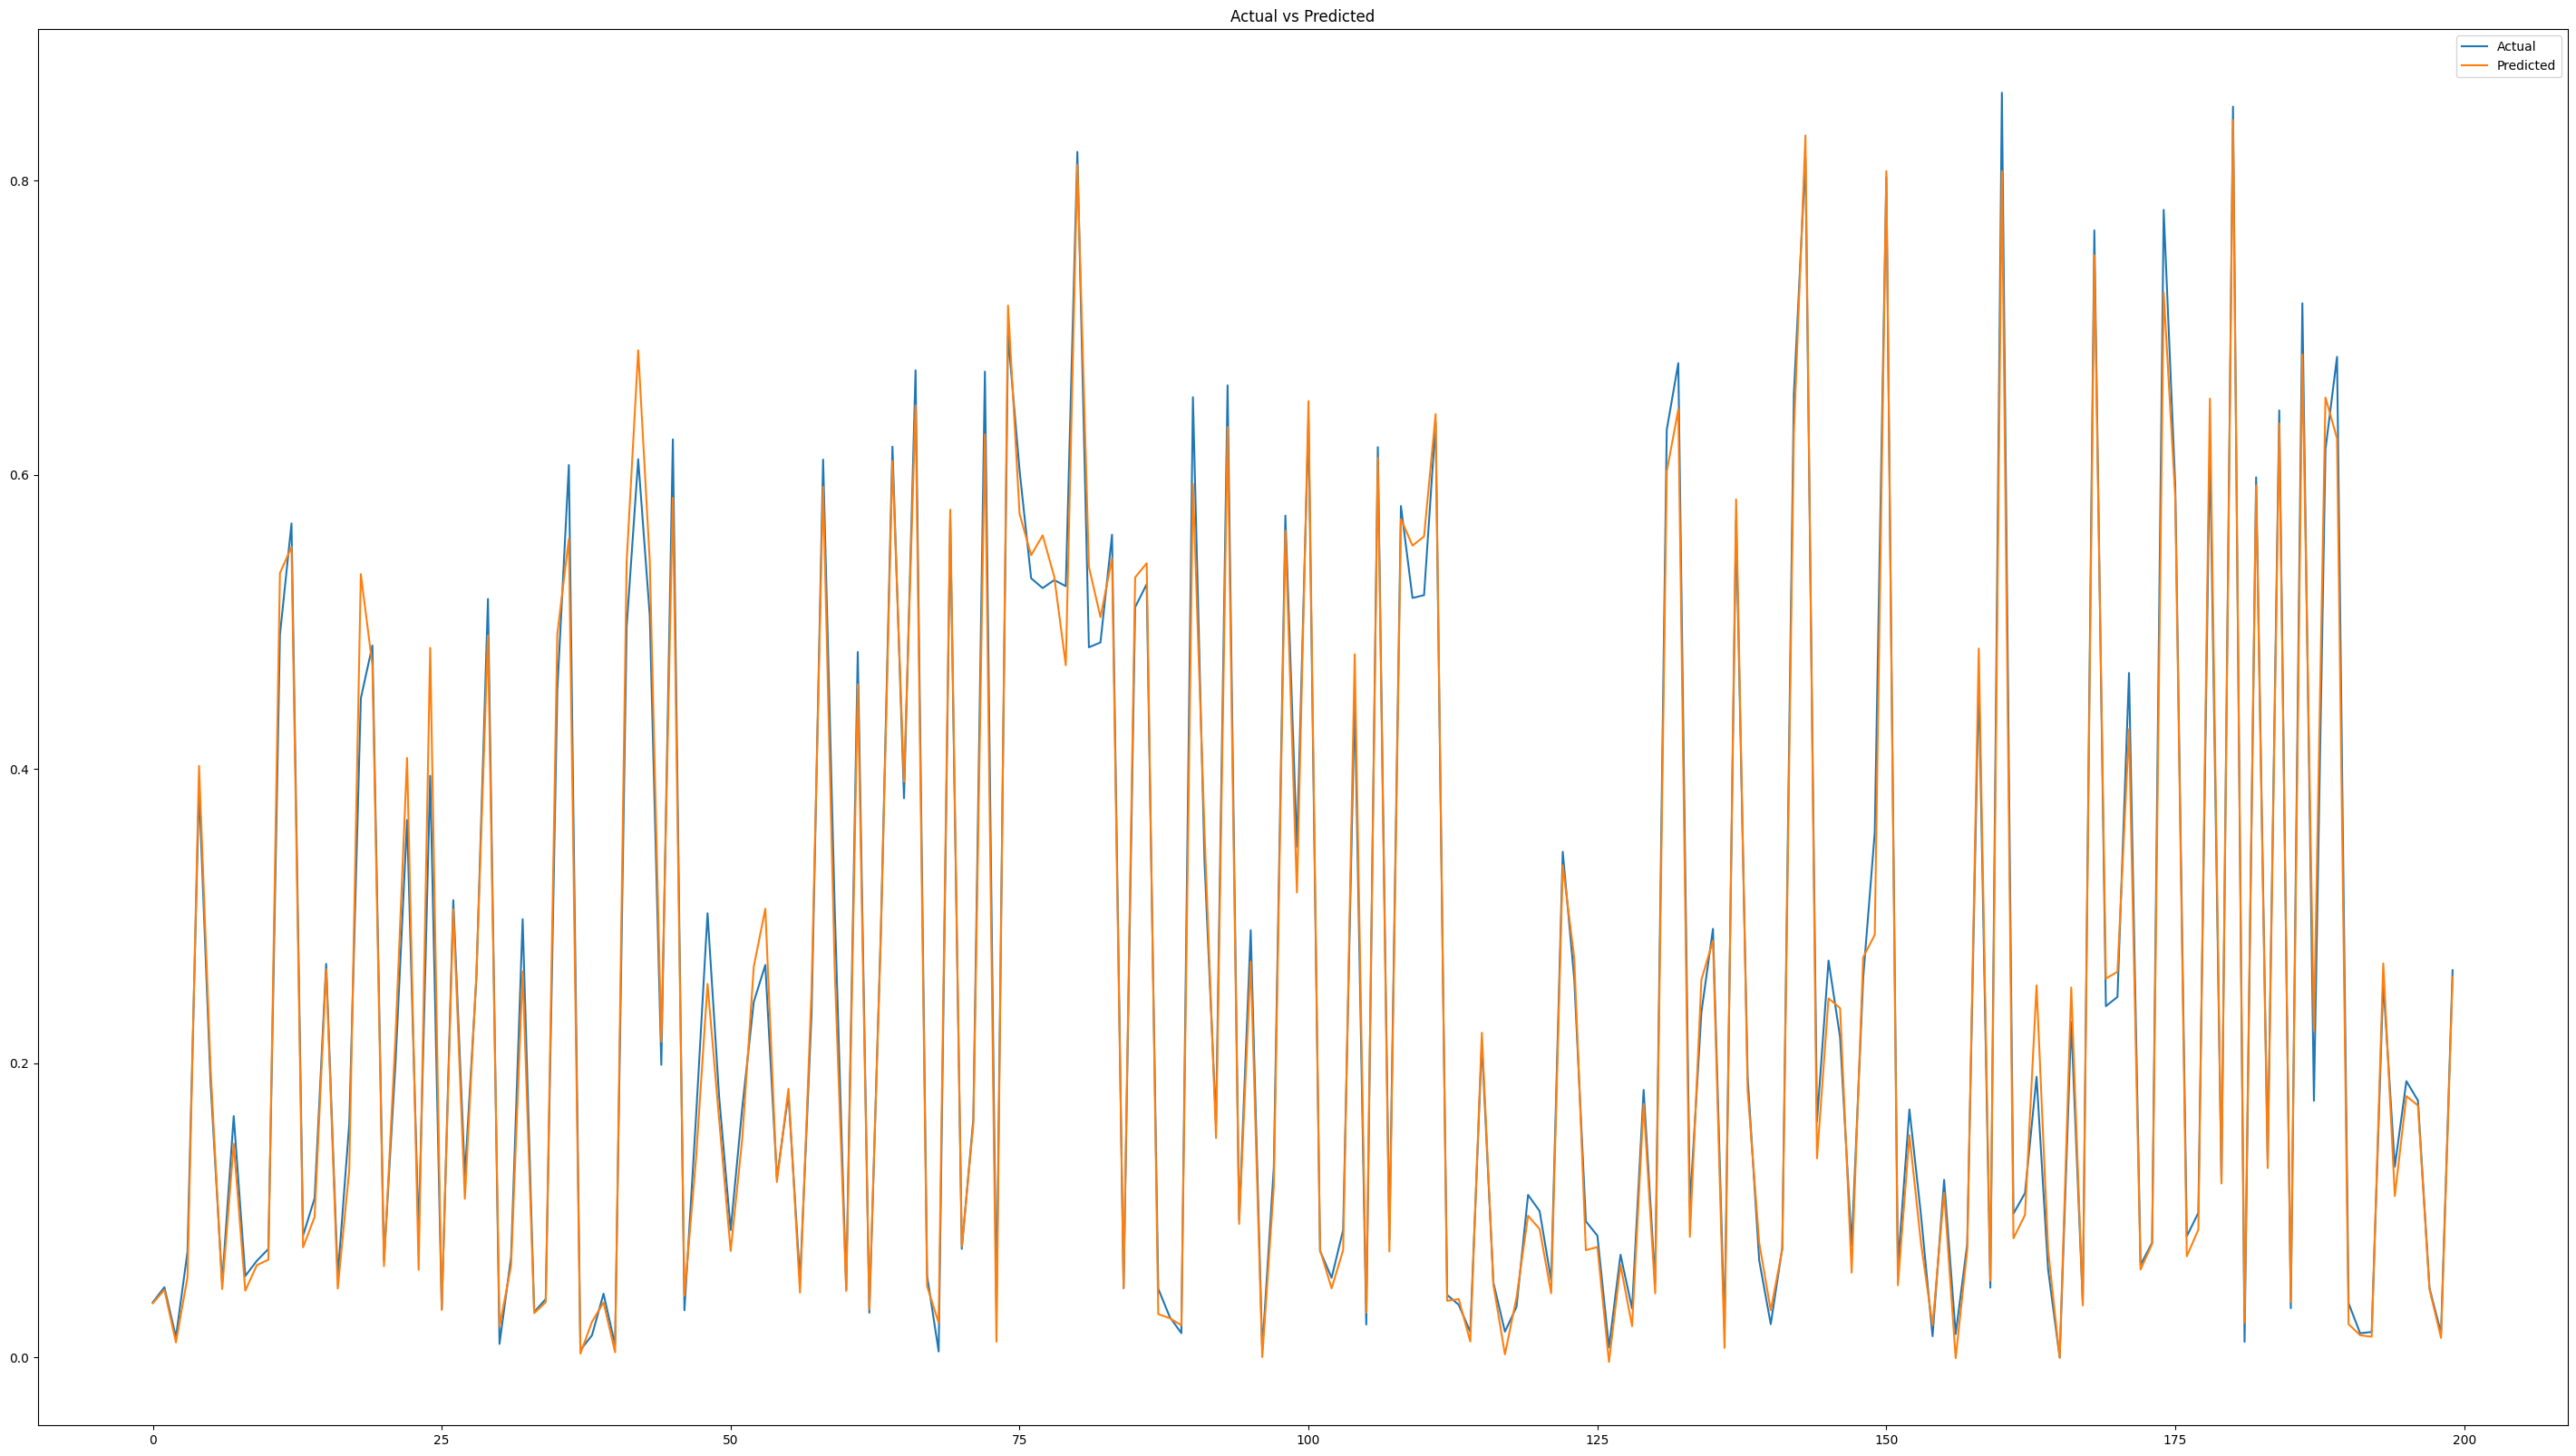

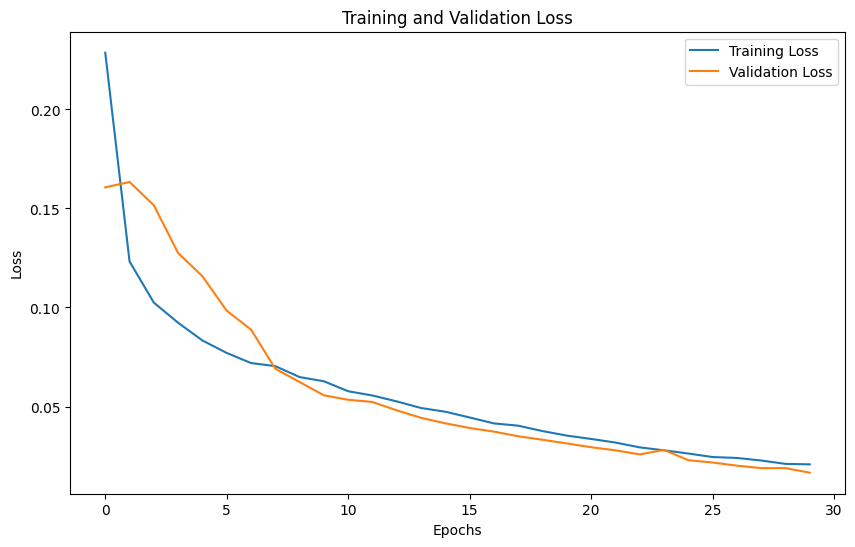

In [10]:
# 시각화
plt.figure(figsize=(36, 20))
plt.plot(y_test[100:300].flatten(), label='Actual')
plt.plot(y_pred[100:300].flatten(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### 4.2 LSTM

In [11]:
# 시퀀스별로 Min-Max 정규화
scaler = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)
y_scaled = scaler.fit_transform(y)


# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 초기화 함수 정의
initializer = GlorotNormal()

# 모델 구성
model2 = Sequential()
model2.add(LSTM(128, input_shape=(SEQ_SIZE, X_train.shape[2]), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.002)))
model2.add(Dense(1))
optimizer = Adam(learning_rate=0.001)

model2.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model2.fit(X_train, y_train, epochs=EPOCH, validation_split=0.2, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# 모델 평가
loss = model2.evaluate(X_test, y_test)
print(f'테스트 손실: {loss}')

# 예측
y_pred = model2.predict(X_test)


Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.1177 - val_loss: 0.0646
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0621 - val_loss: 0.0473
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0450 - val_loss: 0.0353
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0332 - val_loss: 0.0244
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0235 - val_loss: 0.0179
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0174 - val_loss: 0.0130
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0130 - val_loss: 0.0097
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0095 - val_loss: 0.0073
Epoch 9/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0077 - val_loss: 0.0057
Epoch 10/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0060 - val_loss: 0.0045
Epoch 11/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 12/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0

In [12]:
# 성능 평가 지표
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {round(mse, 4)}')
print(f'MAE: {round(mae, 4)}')


MSE: 0.0005
MAE: 0.0152


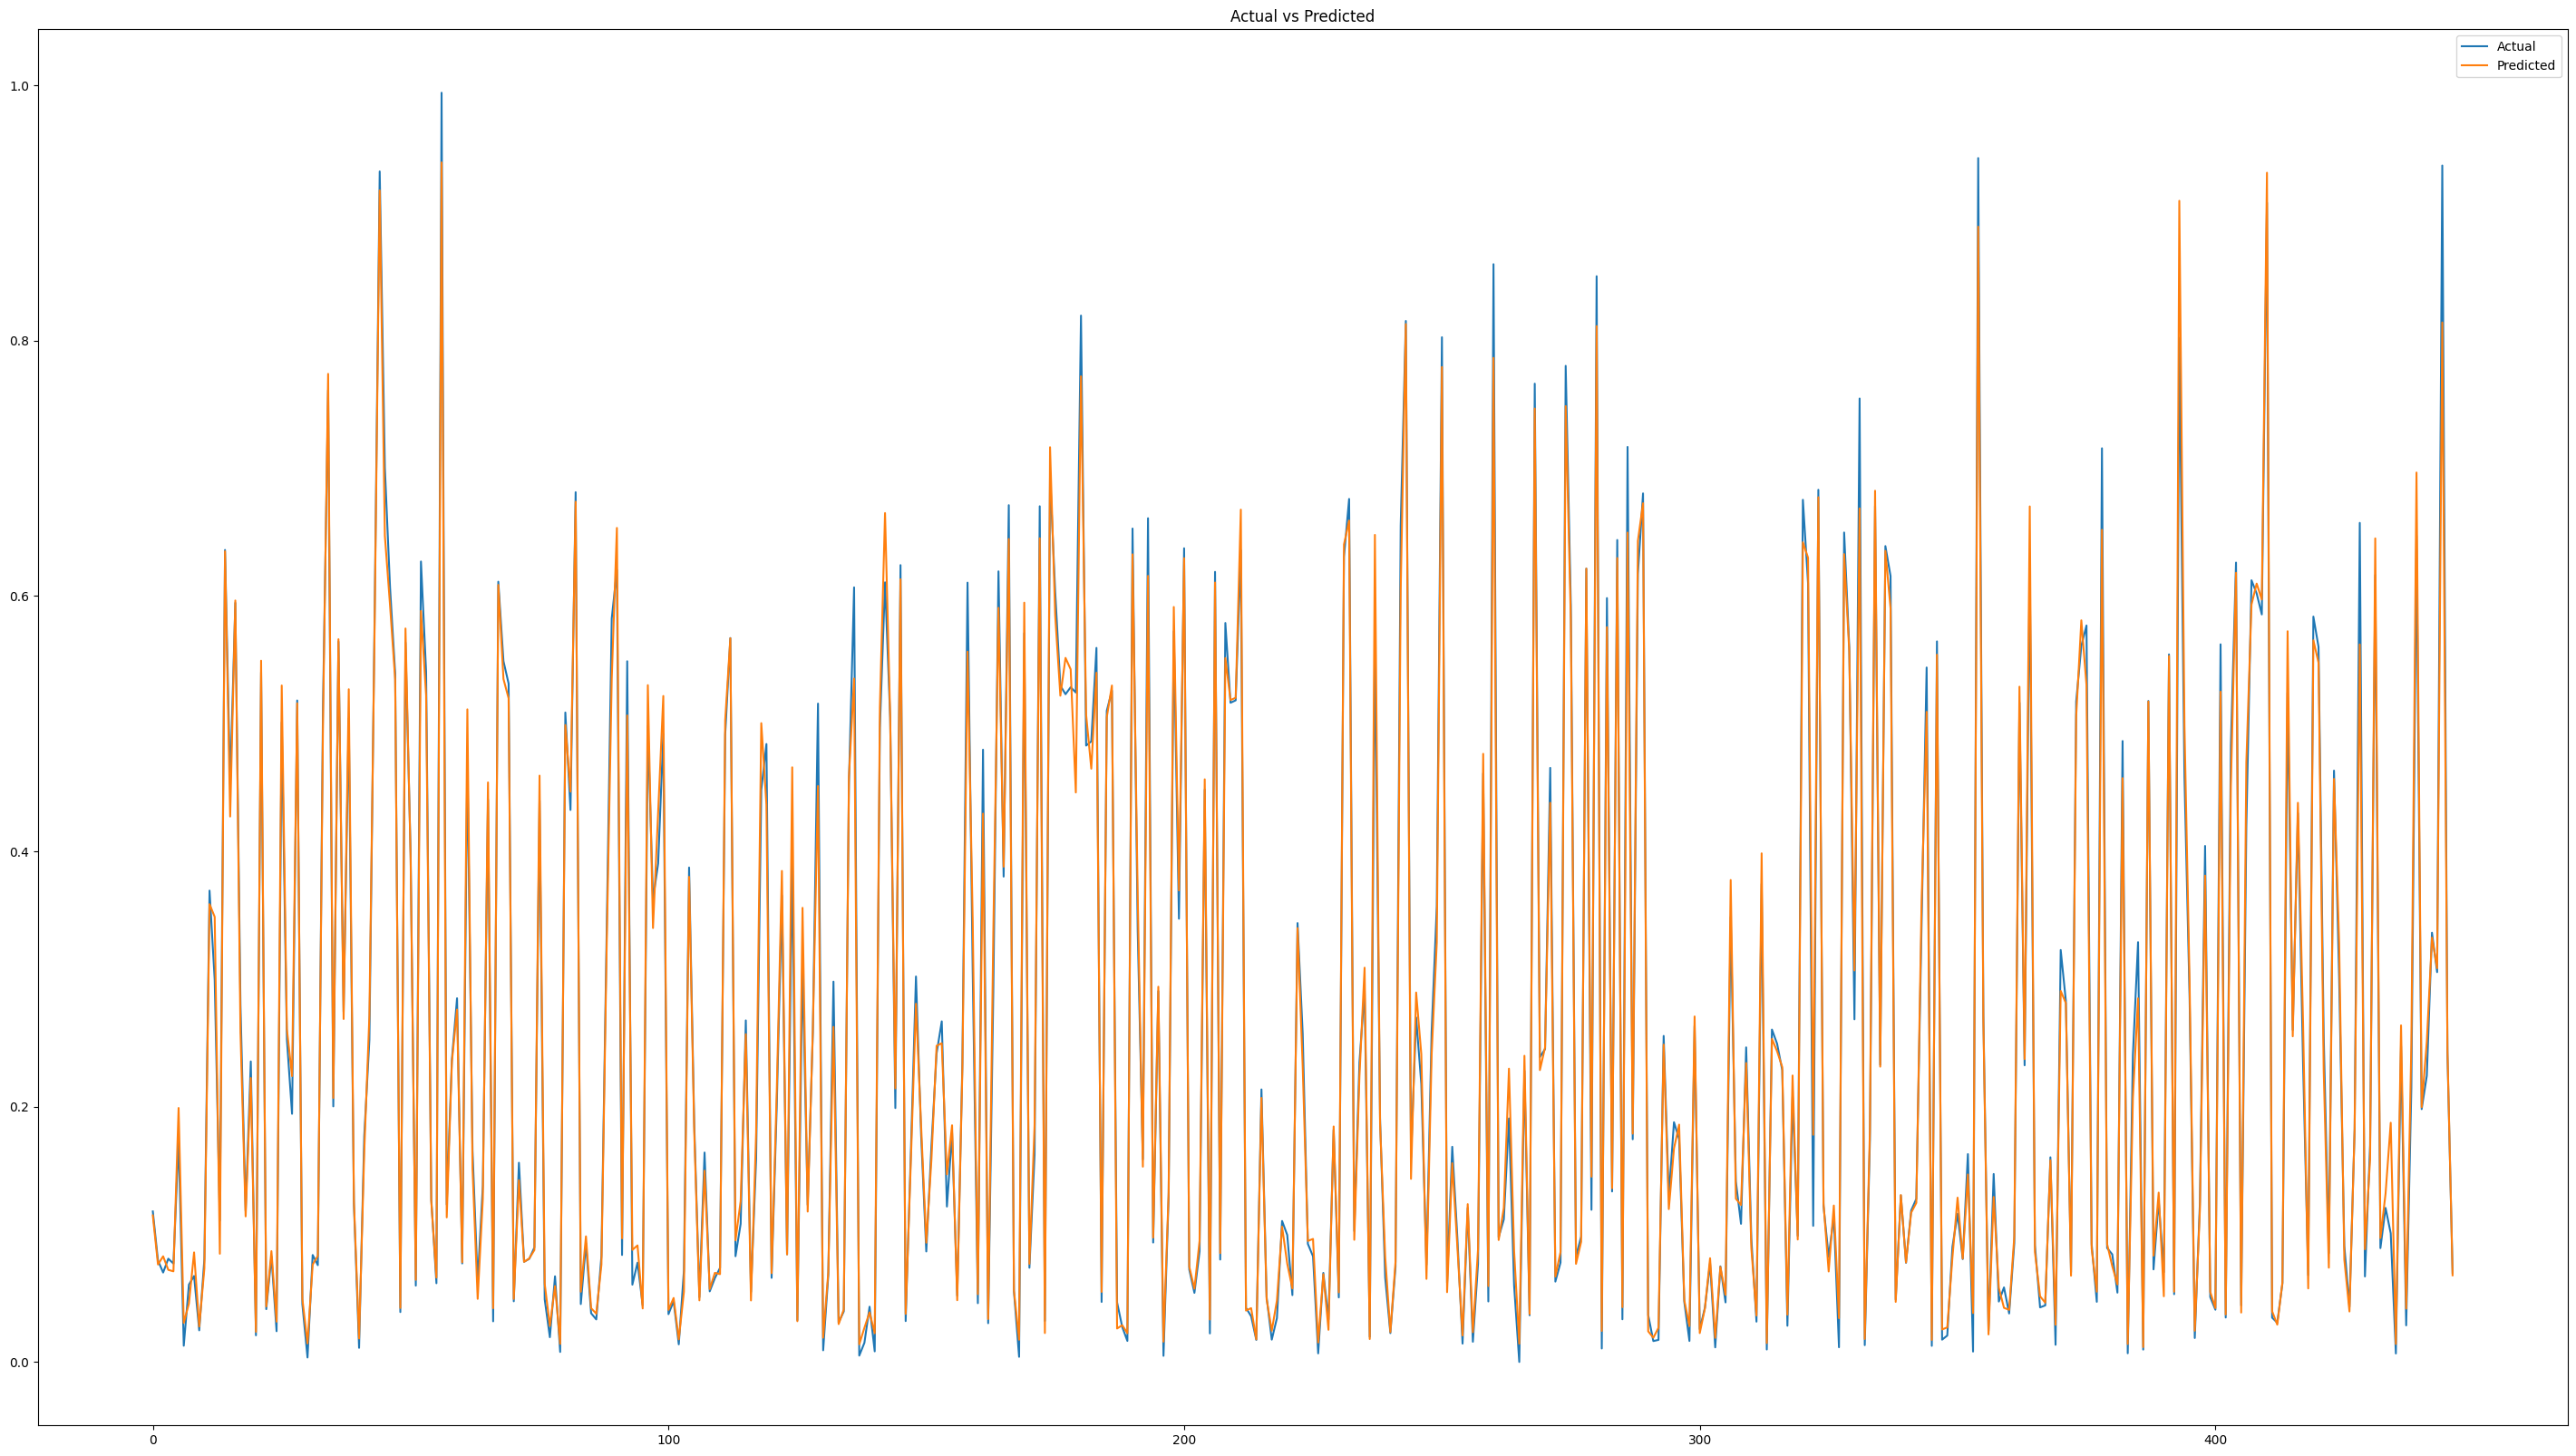

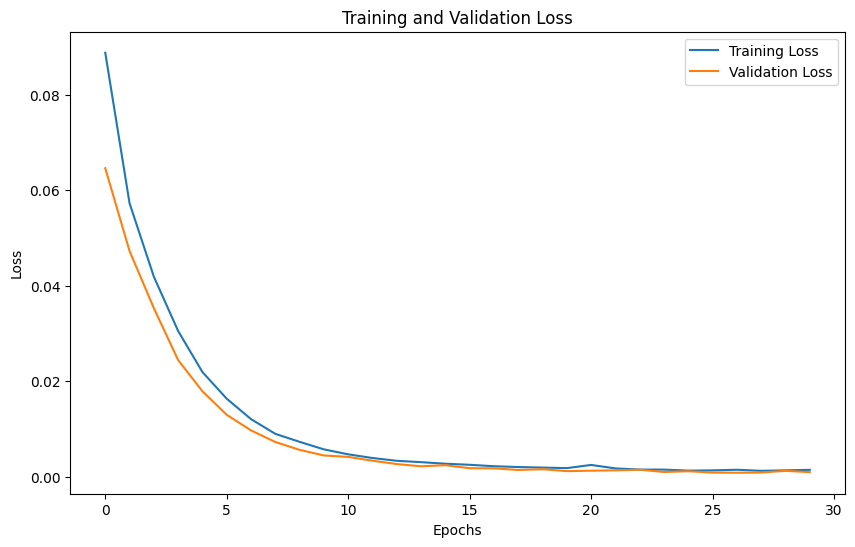

In [13]:

# 시각화
plt.figure(figsize=(36, 20))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(y_pred.flatten(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## 5. 최종 모델 선정

MSE 값을 비교한 결과, LSTM의 성능이 더 좋은 것으로 보임.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


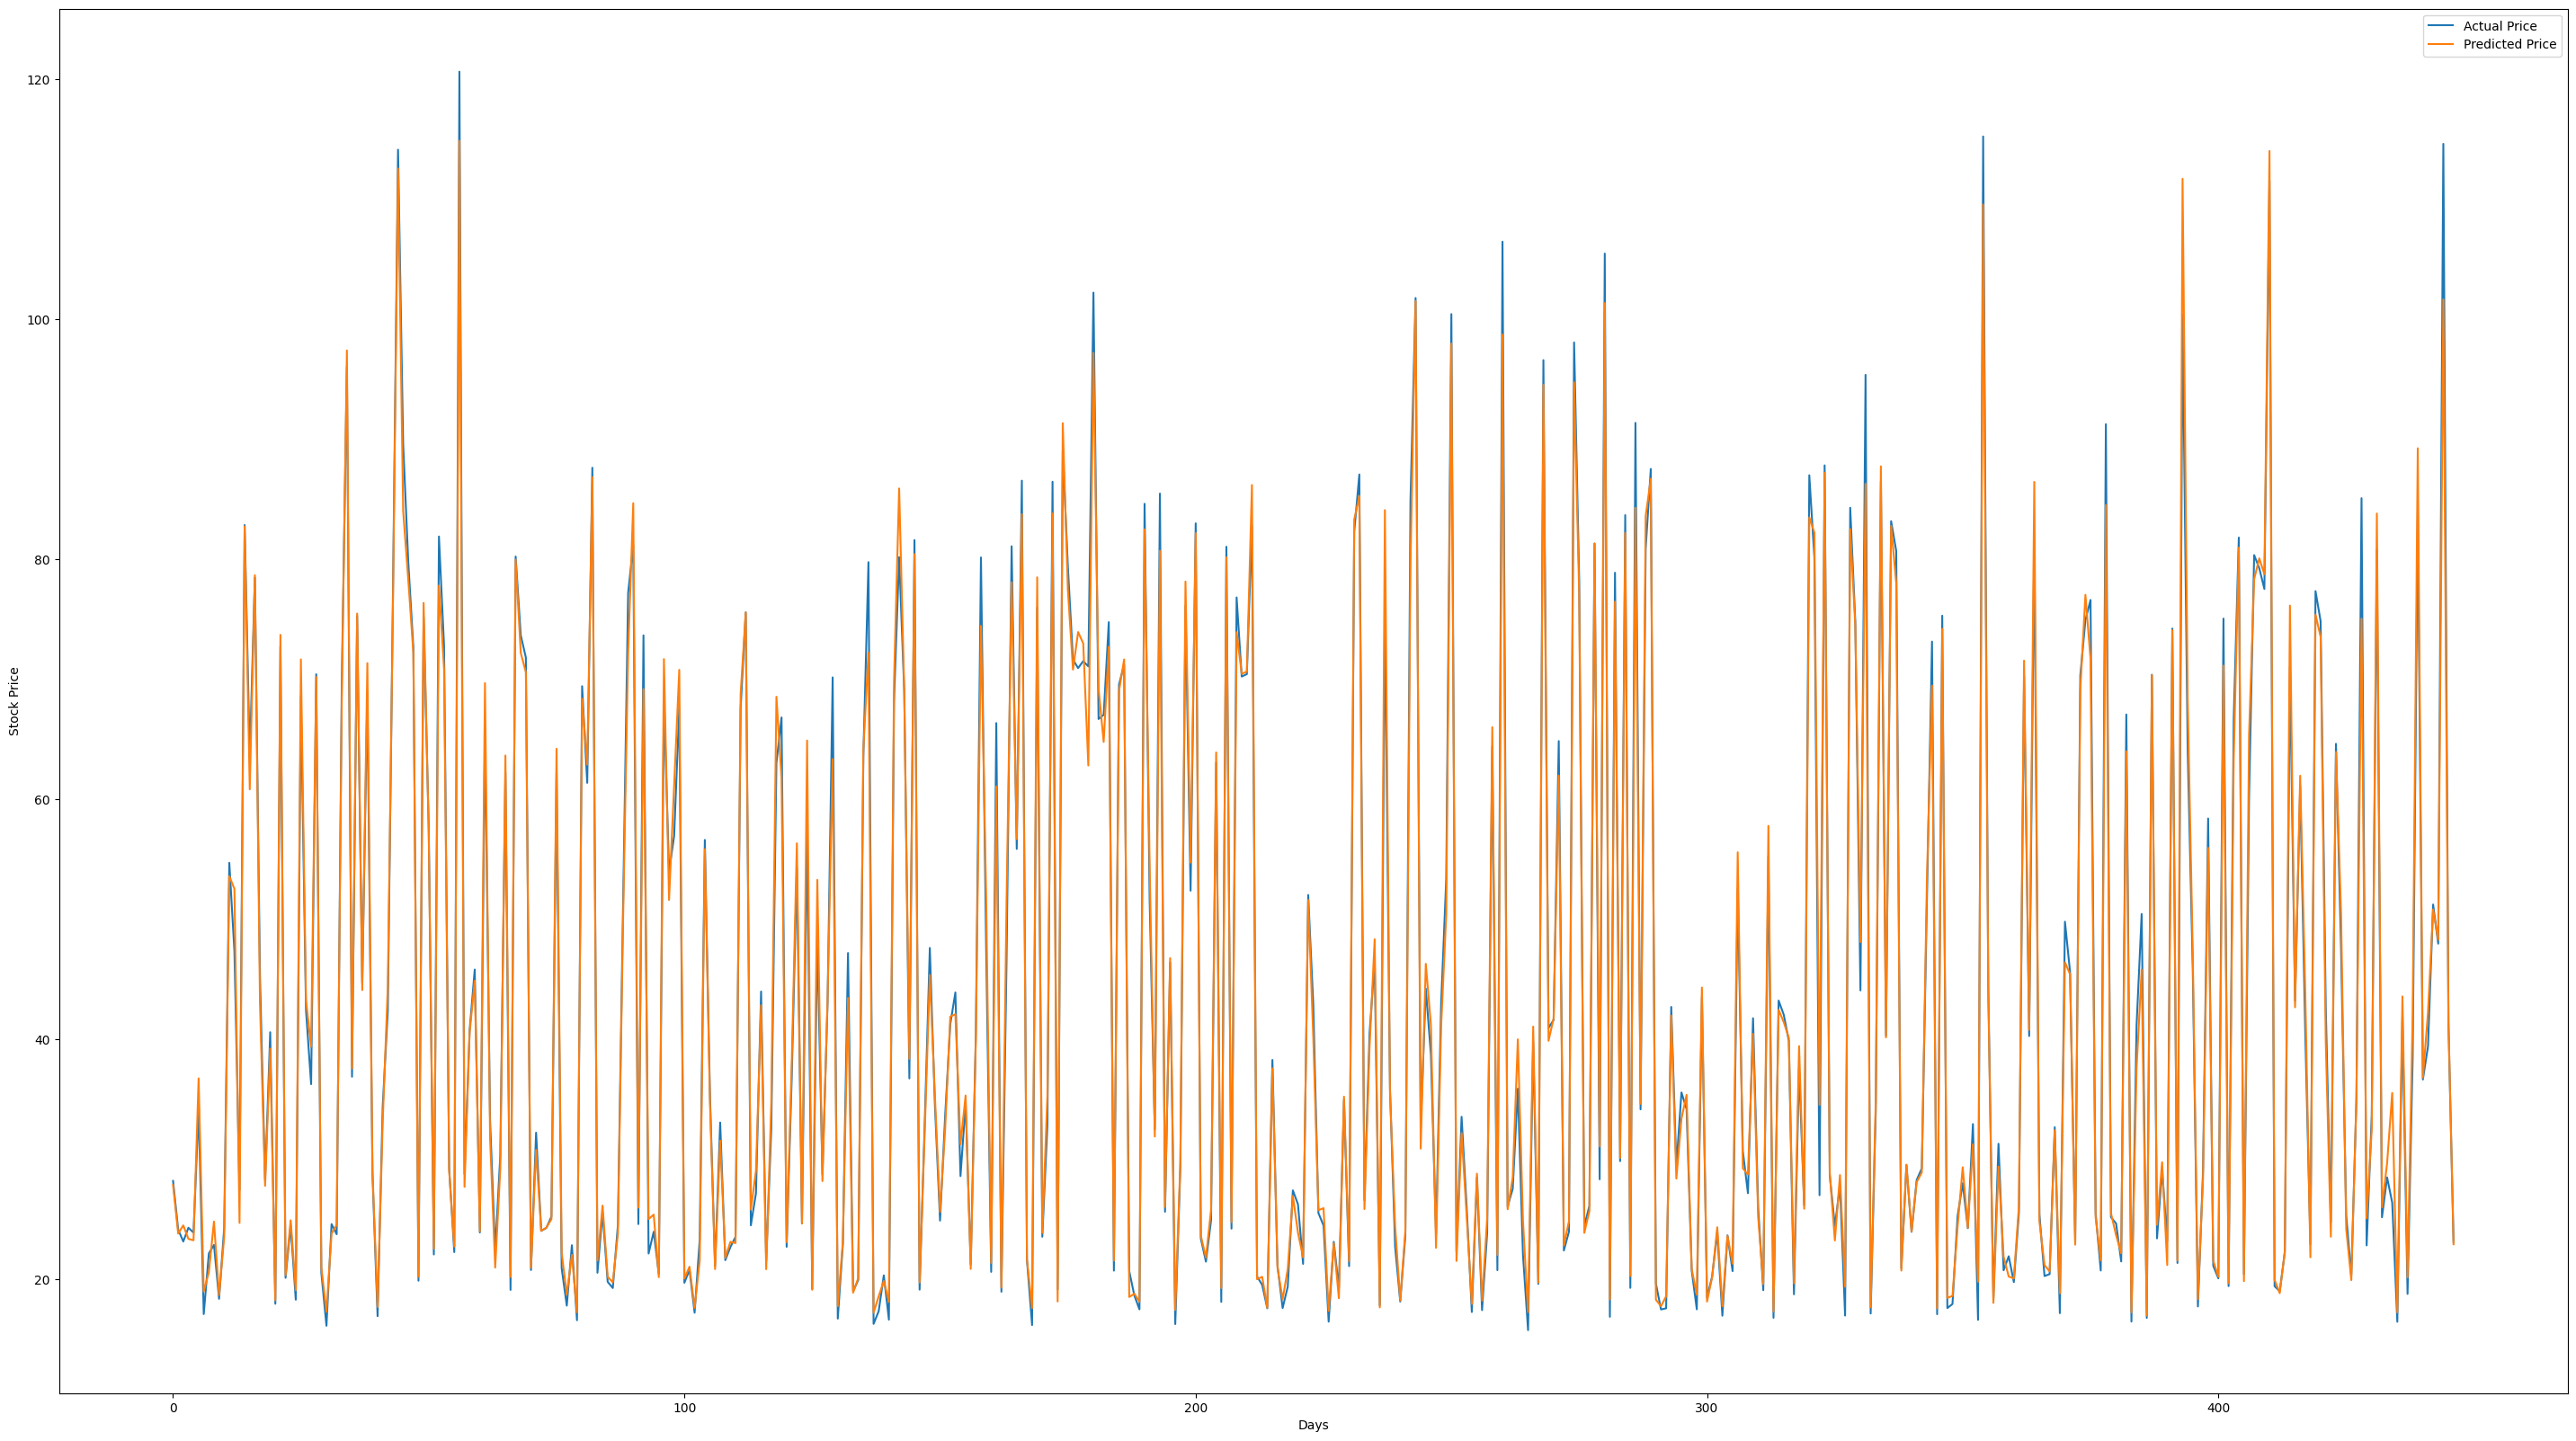

In [14]:
# 테스트 데이터 예측
predicted_price = model2.predict(X_test)

# 원래 스케일로 변환
predicted_price = scaler.inverse_transform(predicted_price.reshape(-1, 1))
real_price = scaler.inverse_transform(y_test.reshape(-1, 1))

# 예측 결과 시각화
plt.figure(figsize=(36,20))
plt.plot(real_price, label='Actual Price')
plt.plot(predicted_price, label='Predicted Price')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [15]:
print(X_train.shape)  # (samples, SEQ_SIZE, features)


(1786, 50, 6)


In [16]:
future_days = 300  # 예측하고 싶은 미래 일 수
future_prices = []

recent_data = X_scaled[-SEQ_SIZE:].reshape(50, SEQ_SIZE, X_train.shape[2])

for i in range(future_days):
    predicted_price = model2.predict(recent_data)  # 하루 예측
    future_prices.append(predicted_price[0][0])  # 결과 저장

    # 예측된 값을 feature 차원에 맞춰 변환
    predicted_value = np.full((50, 1, X_train.shape[2]), predicted_price[0][0])  

    # 최근 데이터를 업데이트 (Sliding Window 방식)
    new_data = np.append(recent_data[:, 1:, :], predicted_value, axis=1)
    recent_data = new_data  # 최신 데이터로 갱신

# 원래 가격으로 변환
future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))
print(f"예측된 미래 {future_days}일 주가: {future_prices.flatten()}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━

In [17]:
print('50일 뒤 가격:', future_prices[49])
print('100일 뒤 가격:', future_prices[99])
print('200일 뒤 가격:', future_prices[199])
print('300일 뒤 가격:', future_prices[299])

50일 뒤 가격: [71.53256]
100일 뒤 가격: [83.10222]
200일 뒤 가격: [85.1236]
300일 뒤 가격: [85.16748]
